# 比較 DBSCAN 與 HDBSCAN 分群演算法

本教學展示 DBSCAN 與 HDBSCAN 分群演算法在合成資料集上的差異。

兩者皆為基於密度的分群方法，但 HDBSCAN 擴展了 DBSCAN，具備階層式分群能力，並能更好地處理不同密度的群集。

我們將會：
- 匯入所需程式庫
- 建立並視覺化範例資料集
- 套用 DBSCAN 與 HDBSCAN 分群
- 比較分群結果
- 視覺化分群標記
- 參數敏感度分析

**參考資料：**
- [scikit-learn DBSCAN 文件](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html)
- [HDBSCAN 文件](https://hdbscan.readthedocs.io/en/latest/)
- [scikit-learn DBSCAN vs HDBSCAN 範例](https://scikit-learn.org/stable/auto_examples/cluster/plot_hdbscan.html)

---

## 1. 匯入所需程式庫

我們將匯入 NumPy、matplotlib、scikit-learn 及 hdbscan 這些常用的資料處理、視覺化與分群分析套件。


In [1]:
# 匯入所需程式庫
import hdbscan
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import DBSCAN

## 2. 建立並視覺化範例資料集

我們將使用 `make_blobs` 產生三個群集及部分雜訊的合成資料集，藉此說明 DBSCAN 與 HDBSCAN 如何處理群集與離群值。

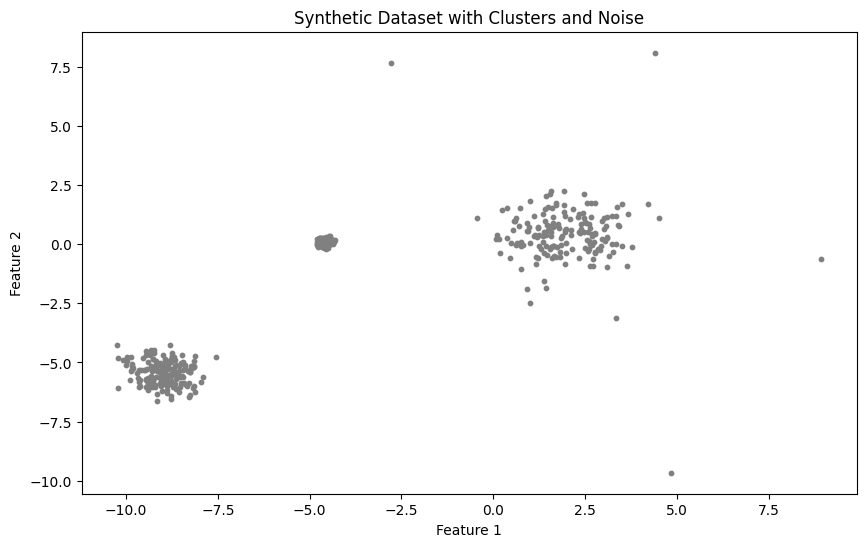

In [2]:
# 產生合成資料集
n_samples = 500
random_state = 170

# Scikit-learn 的 make_blobs 函數可用於產生合成資料集，常用於分群與分類任務。
X, y_true = make_blobs(
  n_samples=n_samples, # 定義樣本數量
  n_features=2,        # 定義特徵數量
  centers=3,           # 定義群集數量
  # cluster_std 定義群集的標準差，影響群集的分布與重疊程度。
  cluster_std=[0.5, 0.1, 0.9],
  random_state=random_state
)

# 加入隨機雜訊
rng = np.random.RandomState(random_state)
# 模擬 10 筆新的 2D 離群點作為雜訊。
X = np.concatenate(
  [
    X,
    rng.uniform(
      low=-10,
      high=10,
      size=(10, 2)     # 產生 10 筆 2D 離群點
    )
  ],
  axis=0
)

# 視覺化資料
plt.figure(figsize=(10, 6))
plt.scatter(X[:, 0], X[:, 1], s=10, color='gray')
plt.title('Synthetic Dataset with Clusters and Noise')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

---

## 3. 套用 DBSCAN 分群 (eps=0.6)

DBSCAN 會將密度較高區域的點分為同一群，並將低密度區域的點標記為雜訊（noise）。

以下套用 DBSCAN 並視覺化結果。

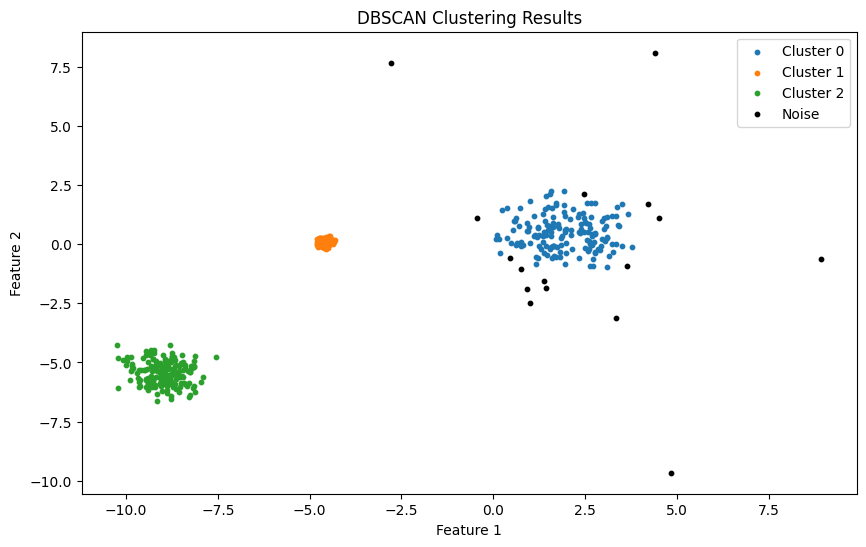

In [3]:
# 套用 DBSCAN
# eps：兩個樣本被視為鄰居的最大距離 (epsilon)
# min_samples：一個點成為核心點 (core point) 所需的最小鄰居數量
dbscan = DBSCAN(
    eps=0.6,        # 兩個點被視為鄰居的最大距離
    min_samples=10  # 一個群集至少需要的樣本數量
)
dbscan_labels = dbscan.fit_predict(X)

# 視覺化 DBSCAN 結果
plt.figure(figsize=(10, 6))
unique_labels = set(dbscan_labels)
# 為每個群集分配顏色
colors = [
    # 取用 matplotlib 調色盤 tab10 的第 i 個顏色
    plt.cm.tab10(i) for i in range(len(unique_labels))
]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # 雜訊
        col = 'black'
    # builds a boolean mask selecting points assigned to cluster label k
    class_member_mask = (dbscan_labels == k)
    plt.scatter(
        X[class_member_mask, 0],
        X[class_member_mask, 1],
        s=10, # point size
        color=col,
        label=f'Cluster {k}' if k != -1 else 'Noise'
    )

plt.title('DBSCAN Clustering Results')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.show()

---

## 4. 套用 HDBSCAN 分群 (min_cluster_size=10)

HDBSCAN 是 DBSCAN 的階層式版本，能夠找出不同密度的群集，且對參數選擇較不敏感。

以下套用 HDBSCAN 並視覺化結果。

/Users/jonas/.pyenv/versions/anomalyebook-3.11.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/jonas/.pyenv/versions/anomalyebook-3.11.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


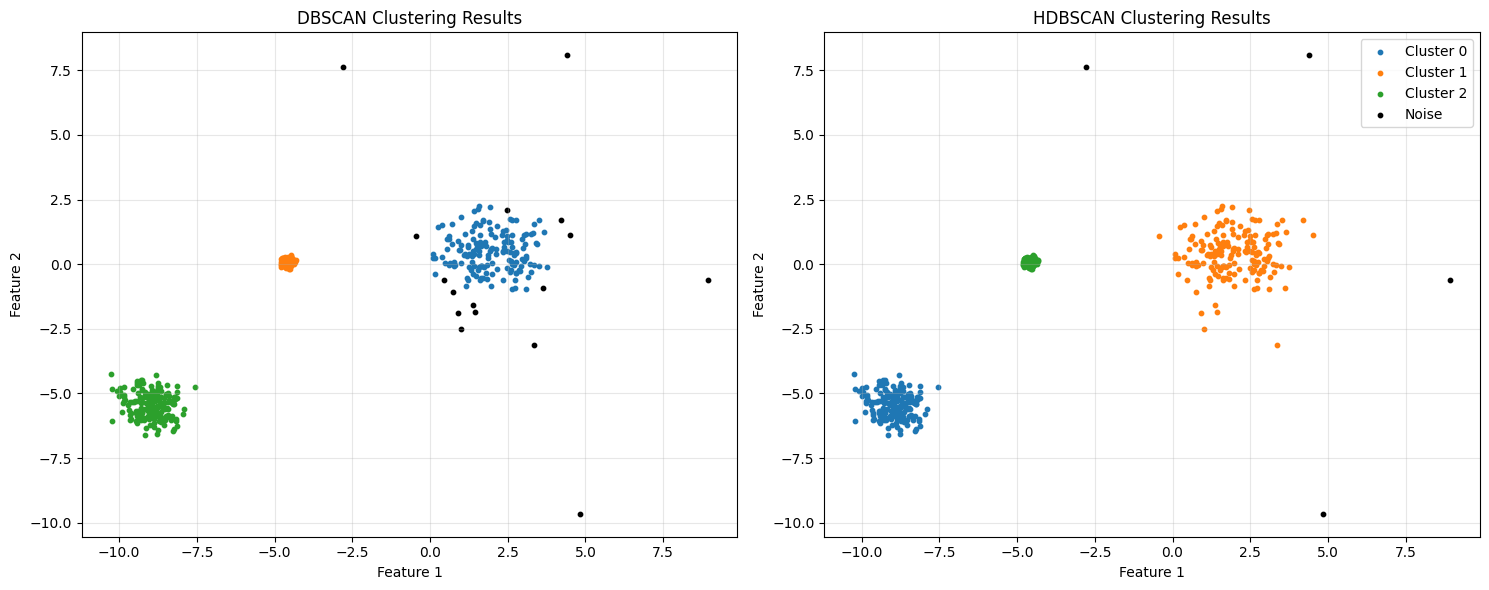

In [4]:
# 視覺化 DBSCAN 和 HDBSCAN 結果比較
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1) # 1-row × 2-column subplot grid

# 與前面相同的 DBSCAN 視覺化程式碼
for k, col in zip(unique_labels, colors):
    if k == -1:
        # 雜訊
        col = 'black'
    class_member_mask = (dbscan_labels == k)
    plt.scatter(
        X[class_member_mask, 0],
        X[class_member_mask, 1],
        s=10, # point size
        color=col,
        label=f'Cluster {k}' if k != -1 else 'Noise'
    )

plt.title('DBSCAN Clustering Results')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.grid(True, alpha=0.3)

# 套用 HDBSCAN
# min_cluster_size：群集的最小大小
hdbscan_clusterer = hdbscan.HDBSCAN(min_cluster_size=10)
hdbscan_labels = hdbscan_clusterer.fit_predict(X)

# 視覺化 HDBSCAN 結果
plt.subplot(1, 2, 2)
unique_labels = set(hdbscan_labels)
colors = [plt.cm.tab10(i) for i in range(len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        col = 'black'
    class_member_mask = (hdbscan_labels == k)
    plt.scatter(
        X[class_member_mask, 0],
        X[class_member_mask, 1],
        s=10, # point size
        color=col,
        label=f'Cluster {k}' if k != -1 else 'Noise'
    )

plt.title('HDBSCAN Clustering Results')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---

## 5. 比較分群結果

我們將比較兩者找到的群集數量、雜訊點數量，並討論 HDBSCAN 的群集穩定性。

In [5]:
# 比較結果
n_dbscan_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_dbscan_noise = np.sum(dbscan_labels == -1)
n_hdbscan_clusters = len(set(hdbscan_labels)) - (1 if -1 in hdbscan_labels else 0)
n_hdbscan_noise = np.sum(hdbscan_labels == -1)

print(f"DBSCAN: {n_dbscan_clusters} clusters, {n_dbscan_noise} noise points")
print(f"HDBSCAN: {n_hdbscan_clusters} clusters, {n_hdbscan_noise} noise points")

DBSCAN: 3 clusters, 16 noise points
HDBSCAN: 3 clusters, 4 noise points


---

## 6. HDBSCAN 群集穩定性

HDBSCAN 的群集穩定性（persistence）用來衡量每個群集的穩健程度。

Persistence 穩定性值範圍從 0 到 1，穩定性值越高，表示該群集越持久、越不容易在分群階層中消失。

使用方式：

* 穩定性高的群集更具意義且更可靠。
* 可利用穩定性過濾掉較弱的群集，聚焦於最重要的群集。

In [6]:
# 群集穩定性（僅 HDBSCAN）
if hasattr(hdbscan_clusterer, 'cluster_persistence_'):
    print("HDBSCAN cluster stability (persistence):", hdbscan_clusterer.cluster_persistence_)

HDBSCAN cluster stability (persistence): [0.10939532 0.05911227 0.58538886]


解讀方式：

* 陣列中的每個值對應 HDBSCAN 找到的群集。
* 例如 `[0.10939532 0.05911227 0.58538886]` 代表：
  - 群集 0：穩定性 ≈ 0.11（較弱、不穩定）
  - 群集 1：穩定性 ≈ 0.06（非常弱，可能是雜訊或小群體）
  - 群集 2：穩定性 ≈ 0.59（強且明確的群集）

---

## 7. 參數敏感度分析

我們將觀察調整主要參數（如 DBSCAN 的 `eps`、HDBSCAN 的 `min_cluster_size`）對分群結果的影響。

### DBSCAN (eps=0.3 vs eps=1.0)

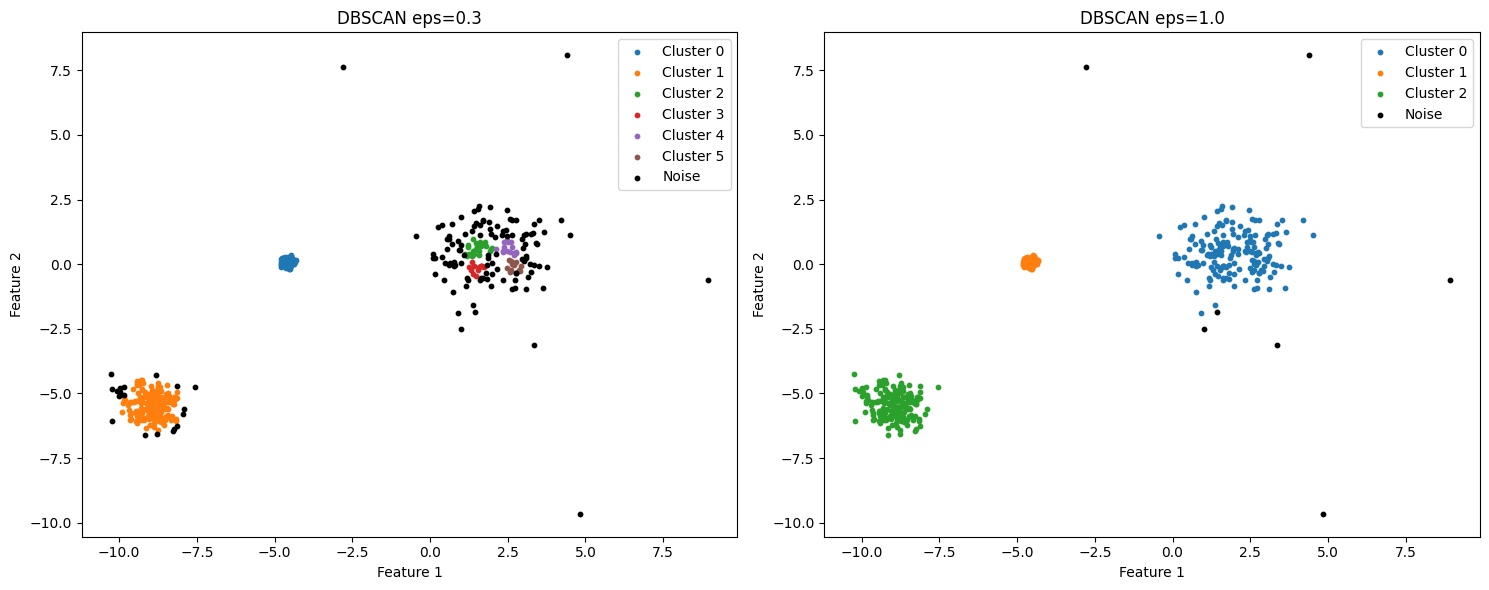

In [7]:
# DBSCAN 參數敏感度分析
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
for ax, eps in zip(axes, [0.3, 1.0]):
    dbscan = DBSCAN(eps=eps, min_samples=10)
    labels = dbscan.fit_predict(X)
    unique_labels = set(labels)
    colors = [plt.cm.tab10(i) for i in range(len(unique_labels))]
    for k, col in zip(unique_labels, colors):
        if k == -1:
            col = 'black'
        class_member_mask = (labels == k)
        ax.scatter(
            X[class_member_mask, 0],
            X[class_member_mask, 1],
            s=10,
            color=col,
            label=f'Cluster {k}' if k != -1 else 'Noise'
        )

    ax.set_title(f'DBSCAN eps={eps}')
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    ax.legend()

plt.tight_layout()
plt.show()

### HDBSCAN (min_cluster_size=5 vs min_cluster_size=30)

/Users/jonas/.pyenv/versions/anomalyebook-3.11.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/jonas/.pyenv/versions/anomalyebook-3.11.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/jonas/.pyenv/versions/anomalyebook-3.11.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/jonas/.pyenv/versions/anomalyebook-3.11.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


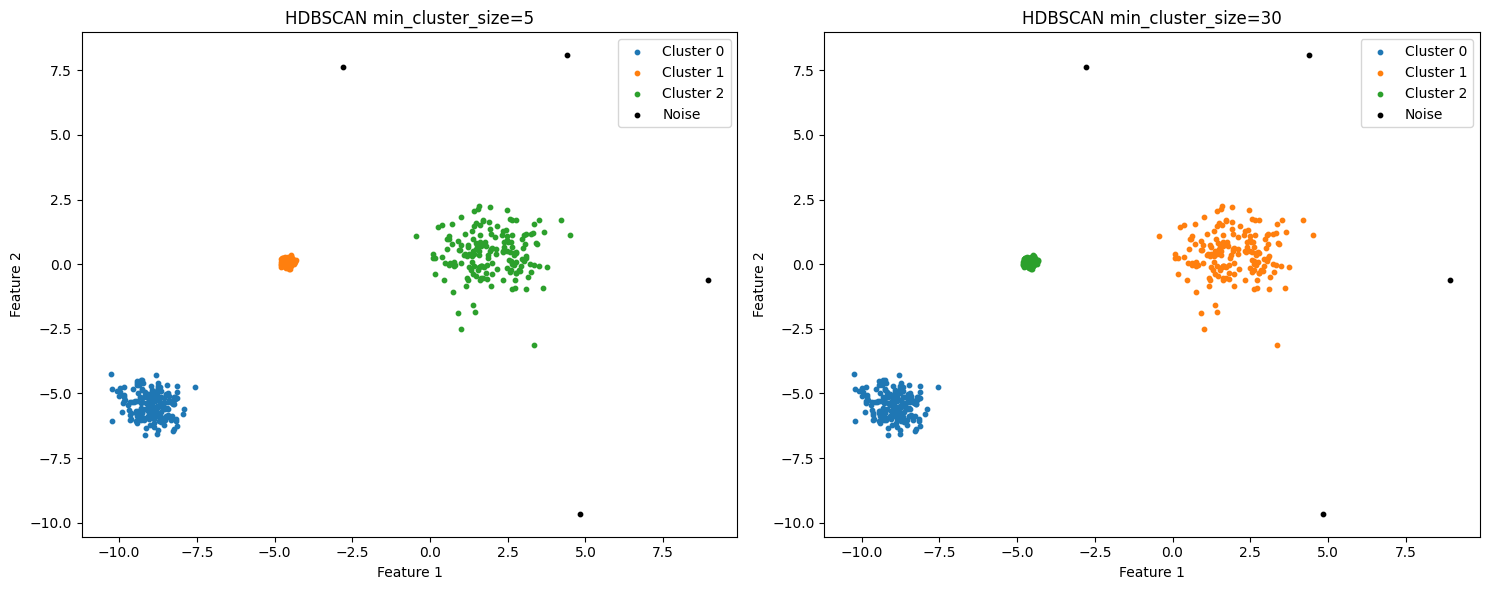

In [8]:
# HDBSCAN 參數敏感度分析
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
for ax, min_cluster_size in zip(axes, [5, 30]):
    clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size)
    labels = clusterer.fit_predict(X)
    unique_labels = set(labels)
    colors = [plt.cm.tab10(i) for i in range(len(unique_labels))]
    for k, col in zip(unique_labels, colors):
        if k == -1:
            col = 'black'
        class_member_mask = (labels == k)
        ax.scatter(
            X[class_member_mask, 0],
            X[class_member_mask, 1],
            s=10,
            color=col,
            label=f'Cluster {k}' if k != -1 else 'Noise'
        )

    ax.set_title(f'HDBSCAN min_cluster_size={min_cluster_size}')
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    ax.legend()

plt.tight_layout()
plt.show()

---

## 8. 總結與討論

- **DBSCAN** 適合找尋密度相近的群集並標記雜訊，但對 `eps` 參數較敏感，且難以處理不同密度的群集。
- **HDBSCAN** 擴展 DBSCAN，具備階層式分群能力，能更好地處理不同密度的群集，且對參數選擇較不敏感，並提供群集穩定性分數。

**使用時機：**
- 當資料為簡單、分離明顯且密度相近時，建議使用 DBSCAN。
- 當資料較複雜、群集密度差異大或參數調整困難時，建議使用 HDBSCAN。

**參考資料：**
- [scikit-learn DBSCAN 文件](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html)
- [HDBSCAN 文件](https://hdbscan.readthedocs.io/en/latest/)
- [scikit-learn DBSCAN vs HDBSCAN 範例](https://scikit-learn.org/stable/auto_examples/cluster/plot_hdbscan.html)
